# Doubles

Created by Kidror

In [527]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE

all_files = glob.glob("roll_data/*-doubles.csv")

df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

season = 14
df = df[df['season'] == season]
len(df)

5164

In [528]:
dfc = df.copy()
for exclude_mod in ["O_NO", "ON_FIRE", "OVERPERFORMING", "UNDERPERFORMING", "GROWTH", "HIGH_PRESSURE", "SINKING_SHIP", "TRAVELING", "CHUNKY", "SMOOTH", "SHELLED"]:
    dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["fielder_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]

batter_params = ['batter_buoyancy', 'batter_divinity', 'batter_martyrdom', 'batter_moxie', 'batter_musclitude', 'batter_patheticism', 'batter_thwackability', 'batter_tragicness', 'batter_coldness', 'batter_overpowerment', 'batter_ruthlessness', 'batter_shakespearianism', 'batter_suppression', 'batter_unthwackability', 'batter_base_thirst', 'batter_continuation', 'batter_ground_friction', 'batter_indulgence', 'batter_laserlikeness', 'batter_anticapitalism', 'batter_chasiness', 'batter_omniscience', 'batter_tenaciousness', 'batter_watchfulness', 'batter_pressurization', 'batter_cinnamon']
pitcher_params = ['pitcher_buoyancy', 'pitcher_divinity', 'pitcher_martyrdom', 'pitcher_moxie', 'pitcher_musclitude', 'pitcher_patheticism', 'pitcher_thwackability', 'pitcher_tragicness', 'pitcher_ruthlessness', 'pitcher_overpowerment', 'pitcher_unthwackability', 'pitcher_shakespearianism', 'pitcher_suppression', 'pitcher_coldness', 'pitcher_base_thirst', 'pitcher_continuation', 'pitcher_ground_friction', 'pitcher_indulgence', 'pitcher_laserlikeness', 'pitcher_anticapitalism', 'pitcher_chasiness', 'pitcher_omniscience', 'pitcher_tenaciousness', 'pitcher_watchfulness', 'pitcher_pressurization', 'pitcher_cinnamon']
for attr in batter_params:
    dfc[attr] = dfc[attr] * df['batter_multiplier']
for attr in pitcher_params:
    dfc[attr] = dfc[attr] * df['pitcher_multiplier']

dfc.loc[dfc["pitcher_mods"].astype(str).str.contains("SCATTERED"),"pitcher_vibes"] = 0
dfc.loc[dfc["batter_mods"].astype(str).str.contains("SCATTERED"),"batter_vibes"] = 0

dfc = dfc[dfc["batter_multiplier"] == 1]
dfc = dfc[dfc["pitcher_multiplier"] == 1]

In [539]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model

dfc["musc_vibes"] = dfc["batter_musclitude"] * (1 + 0.2*dfc["batter_vibes"])
dfc["ind_vibes"] = dfc["batter_indulgence"] * (1 + 0.2*dfc["batter_vibes"])
dfc["gf_vibes"] = dfc["batter_ground_friction"] * (1 + 0.2*dfc["batter_vibes"])
dfc["opw_vibes"] = dfc["pitcher_overpowerment"] * (1 + 0.2*dfc["pitcher_vibes"])
dfc["unthwack_vibes"] = dfc["pitcher_unthwackability"] * (1 + 0.2*dfc["pitcher_vibes"])
dfc["ruth_vibes"] = dfc["pitcher_ruthlessness"] * (1 + 0.2*dfc["pitcher_vibes"])
dfc["shakes_vibes"] = dfc["pitcher_shakespearianism"] * (1 + 0.2*dfc["pitcher_vibes"])
dfc["supp_vibes"] = dfc["pitcher_suppression"] * (1 + 0.2*dfc["pitcher_vibes"])
dfc["chase_vibes"] = dfc["fielder_chasiness"] * (1 + 0.2*dfc["fielder_vibes"])
dfc["cold_vibes"] = dfc["pitcher_coldness"] * (1 + 0.2*dfc["pitcher_vibes"])
dfc["omni_vibes"] = dfc["pitcher_omniscience"] * (1 + 0.2*dfc["pitcher_vibes"])
dfc["invpath"] = 1 - dfc["batter_patheticism"] * (1 + 0.2*dfc["batter_vibes"])
dfc["park_park"] = dfc["ballpark_forwardness"] + dfc["ballpark_viscosity"] - dfc["ballpark_ominousness"]

X = dfc[["roll",'musc_vibes', "opw_vibes", "chase_vibes", "ballpark_forwardness", "ballpark_viscosity", "ballpark_ominousness", "ballpark_grandiosity", "ballpark_obtuseness", "ballpark_inconvenience", "ballpark_elongation"]]
y = dfc['passed']

sc = StandardScaler()
X2 = sc.fit_transform(X)

trainedsvm = svm.LinearSVC(dual=False, C=10000, max_iter=10000, tol=1e-5).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
confusion_matrix(y,predictionsvm)

array([[2110,    0],
       [   0,  615]], dtype=int64)

In [540]:
print(len(dfc[~dfc["passed"]]))
print(len(dfc[dfc["passed"]]))

2110
615


In [541]:
coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]
sorted(zip(coef_list, X.columns), key=lambda x: abs(x[0]), reverse=True)

[(1.0, 'roll'),
 (-0.19669777222032006, 'musc_vibes'),
 (-0.08845459306454934, 'ballpark_forwardness'),
 (0.07572239691191829, 'chase_vibes'),
 (0.048247506414262516, 'ballpark_ominousness'),
 (0.03655461926037482, 'opw_vibes'),
 (0.03168978528617555, 'ballpark_elongation'),
 (0.02164412679269395, 'ballpark_obtuseness'),
 (0.014407804239633731, 'ballpark_inconvenience'),
 (0.007726252285789987, 'ballpark_viscosity'),
 (0.005122137780413022, 'ballpark_grandiosity')]

In [523]:
intercept = trainedsvm.intercept_ - np.dot(coef, sc.mean_)
intercept_scaled = intercept / coef[0, 0]
intercept_scaled

array([-0.1617746])

In [524]:
opw = dfc["pitcher_overpowerment"] * (1 + 0.2*dfc["pitcher_vibes"])
grand = dfc["ballpark_grandiosity"]
vis = dfc["ballpark_viscosity"]
fwd = dfc["ballpark_forwardness"]
omi = dfc["ballpark_ominousness"]
elong = dfc["ballpark_elongation"]
musc = dfc["batter_musclitude"] * (1 + 0.2*dfc["batter_vibes"])
sup = dfc["pitcher_suppression"] * (1 + 0.2*dfc["pitcher_vibes"])
omni = dfc["pitcher_omniscience"] * (1 + 0.2*dfc["pitcher_vibes"])
obtuse = dfc["ballpark_obtuseness"]
incon = dfc["ballpark_inconvenience"]
chase = dfc["fielder_chasiness"] * (1 + 0.2*dfc["fielder_vibes"])
cold = dfc["pitcher_coldness"] * (1 + 0.2*dfc["pitcher_vibes"])

# Musc, OPW, FWD, Grand, OMI, Probably Fielder Chasiness
# S12 & 13- 0.17 + 0.2*musc - 0.1*chase - 0.04*opw
# S14 0.1575 + 0.2*musc - 0.09*chase - 0.04*opw - 0.0125*vis + 0.0275*fwd + 0.006*omi

dfc["threshold"] = 0.1565 + 0.2*musc - 0.1*chase - 0.04*opw - 0.0125*vis + 0.0275*fwd + 0.0065*omi

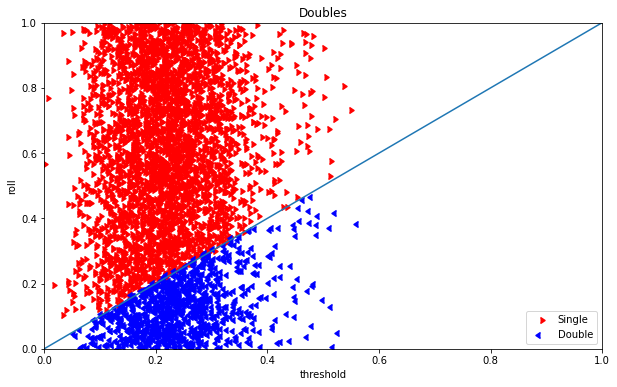

In [525]:
x_val = "threshold"
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.scatter(dfc[~dfc['passed']][x_val], dfc[~dfc['passed']]["roll"], color="red",
           label="Single", marker=CARETRIGHTBASE)
ax.scatter(dfc[dfc['passed']][x_val], dfc[dfc['passed']]["roll"], color="blue",
           label="Double", marker=CARETLEFTBASE)
ax.plot([0, 1], [0, 1])
ax.set_xlabel(x_val)
ax.set_ylabel('roll')
ax.set_title("Doubles")
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.legend()

,offset,weather,event_type,batter_ground_friction,pitcher_overpowerment,roll,threshold,fielder_name,fielder_chasiness,batter_name,pitcher_name,batter_mods,pitcher_mods,batting_team_mods,pitching_team_mods,day,game_id,play_count
7333,-0.002234,Weather.FLOODING,Hit1,0.350426,0.639164,0.300759,0.302994,Kelvin Drumsolo,0.195761,Quack Enjoyable,Jolene Willowtree,NaN,NaN,NaN,MAINTENANCE_MODE,29,26377941-a228-4bde-8d05-56079136df1f,262
9818,-0.000783,Weather.ECLIPSE,Hit1,0.371812,0.216309,0.280941,0.281724,Nandy Fantastic,0.247814,Yusef Puddles,Patty Fox,NaN,NaN,AFFINITY_FOR_CROWS,BIRD_SEED,49,57a329f1-5c82-424b-b39d-2b22007da241,137
5488,0.000012,Weather.REVERB,Hit2,0.232382,1.358705,0.192612,0.192600,Beck Whitney,0.759525,Math Velazquez,Qais Dogwalker,ALTERNATE,FRIEND_OF_CROWS,NaN,LIFE_OF_PARTY;ELECTRIC,10,774eaa1a-e40b-4e7c-8579-d74c0d03740b,273
5547,0.000099,Weather.FEEDBACK,Hit2,0.324850,0.656127,0.161541,0.161443,Liquid Friend,1.005925,Sparks Beans,Gabriel Griffith,NaN,NaN,NaN,LOVE,11,881e6848-431e-4c77-a3d5-d2f4a3658895,79
9317,0.001135,Weather.FEEDBACK,Hit2,0.895354,0.488923,0.304898,0.303762,Aldon Cashmoney,0.266896,Hercules Alighieri,Hiroto Wilcox,NaN,FRIEND_OF_CROWS,UNDERSEA,FIREPROOF;SEALANT;AMBUSH,45,266d827e-909b-43d2-99ec-49f722f8dc17,139
8690,0.002405,Weather.BLACK_HOLE,Hit2,0.802250,0.989889,0.293108,0.290703,Denzel Scott,0.853369,Kaz Fiasco,Alexandria Rosales,NaN,NaN,BOTTOM_DWELLER,NaN,40,684a03c3-230b-4e02-8d17-8adc542038ec,166
11101,0.002549,Weather.BLOODDRAIN,Hit2,0.352606,0.766931,0.290234,0.287685,Siobhan Chark,0.513809,Steph Weeks,Flattery McKinley,FIRE_EATER,ALTERNATE,EARLBIRDS,UNDERSEA;PARTY_TIME,88,5c58de61-5437-4ec3-bf35-d6ea4579c5ad,326
10135,0.003732,Weather.FLOODING,Hit2,0.600793,0.450527,0.178410,0.174678,Roscoe Sundae,0.991097,Paula Turnip,Mullen Peterson,NaN,NaN,FIREPROOF;SEALANT;AMBUSH,NaN,81,8ac77e5c-fa21-4403-9b67-855d6a469e92,153
6388,0.003841,Weather.FLOODING,Hit2,0.930462,0.756174,0.237727,0.233886,Dudley Mueller,1.262130,Loubert Ji-Eun,Jayden Wright,NaN,NaN,BOTTOM_DWELLER,BASE_INSTINCTS,17,1d0d553f-713f-478a-9c1f-cf6d33cfd91e,298
8351,0.003898,Weather.FLOODING,Hit2,0.988950,1.022141,0.201473,0.197576,Ren Hunter,0.577001,Lang Richardson,Fynn Doyle,NaN,ALTERNATE,AFFINITY_FOR_CROWS,BIRD_SEED,38,0ea7896e-81fc-4113-baa5-65abadf5af9d,55


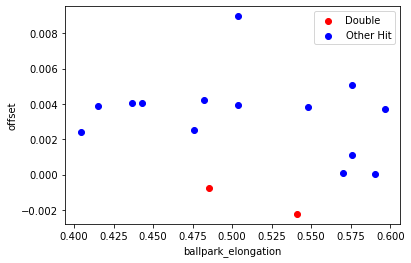

In [526]:
dfc["offset"] = dfc["roll"] - dfc["threshold"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] > 0)) | (~dfc["passed"] & (dfc["offset"] < 0))]

fig, ax = plt.subplots(1)
x_val = "ballpark_elongation"
y_val = "offset"
ax.scatter(outliers[~outliers['passed']][x_val], outliers[~outliers['passed']][y_val], color="red", label="Double")
ax.scatter(outliers[outliers['passed']][x_val], outliers[outliers['passed']][y_val], color="blue", label="Other Hit")
ax.set_xlabel(x_val)
ax.set_ylabel(y_val)
ax.legend()

table = outliers
table[["offset", "weather", "event_type", "batter_ground_friction", "pitcher_overpowerment",
       "roll", "threshold",
       "fielder_name", "fielder_chasiness",
       "batter_name", "pitcher_name", "batter_mods", "pitcher_mods",
       "batting_team_mods", "pitching_team_mods", "day",  "game_id", "play_count"]].sort_values('offset')


In [164]:
print(dfc[dfc["passed"]]["roll"].min())
print(dfc[~dfc["passed"]]["roll"].max())

9.041731090353444e-05
0.9999855637576328
